In [312]:
#standard imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
import time as time

from warnings import filterwarnings
filterwarnings('ignore')

In [313]:
#load dataset
df=pd.read_csv('FINALfeatures.csv')#preprocessed training date from Linear Regression Model
test = pd.read_csv('LRpredictions.csv')
#fill NA
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#set up index
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month


In [314]:
df.rename(columns={'total_cases_x': 'total_cases'}, inplace=True)

In [315]:

sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

sj_test=test[test['city']=='sj']
iq_test=test[test['city']=='iq']

In [362]:
#Create a previous week value using the Linear Model predictions. We take the rolling mean of the last 6 weeks ( 3 for IQ) of linerarly predicted
#total cases and we use last weeks value to try and predict this week. 
#train
sj['cases_last'] = sj['total_cases'].rolling(window = 6).mean()# (sj['total_cases'].shift(6)+ sj['total_cases'].shift(5)+sj['total_cases'].shift(4)+sj['total_cases'].shift(3)+sj['total_cases'].shift(2)) /5
sj['cases_last'] = sj['cases_last'].shift(1)
iq['cases_last'] = iq['total_cases'].rolling(window = 3).mean()
iq['cases_last'] = iq['cases_last'].shift(1) #(iq['total_cases'].shift(3)+ iq['total_cases'].shift(2)+iq['total_cases'].shift(1)) /3


sj_test['cases_last'] = sj_test['total_cases'].rolling(window = 6).mean()# (sj['total_cases'].shift(6)+ sj['total_cases'].shift(5)+sj['total_cases'].shift(4)+sj['total_cases'].shift(3)+sj['total_cases'].shift(2)) /5
sj_test['cases_last'] = sj_test['cases_last'].shift(1)
iq_test['cases_last'] = iq_test['total_cases'].rolling(window =6).mean()
iq_test['cases_last'] = iq_test['cases_last'].shift(1) #(iq['total_cases'].shift(3)+ iq['total_cases'].shift(2)+iq['total_cases'].shift(1)) /3

#need to make sure no NaNs 
sj.fillna(method='bfill', inplace=True)
iq.fillna(method='bfill', inplace=True)

sj_test.fillna(method='bfill', inplace=True)
sj_test.fillna(method='bfill', inplace=True)

In [363]:
#these features performed better
features2=[
'sjmean6',
'sjmean7',
'sjmean8',
'sjmean9',
'sjstd1',
'sjstd5','sjstd6',
'sjstd7','sjstd8','sjstd9',
'sjstd12','sjstd13','sjstd14', 
'sjshift1', 'sjshift2','sjshift3',
'reanalysis_max_air_temp_k','station_max_temp_c','reanalysis_min_air_temp_k',
'reanalysis_air_temp_k','station_min_temp_c',
'total_cases',
'cases_last'
    ]   


features3=[
'iqmeans1',
'iqmeans3',
'iqmeans5','iqmeans6',
'iqmeans8','iqmeans9',
'iqmeans11','iqmeans12','iqmeans13', 
'iqstd5','iqstd6',
'iqstd7','iqstd8',
'iqstd9',
'iqstd10',
'iqstd11', 
'shiftyiq2','shiftyiq3',
'shiftyiq4','shiftyiq5','reanalysis_specific_humidity_g_per_kg',
'reanalysis_dew_point_temp_k','reanalysis_min_air_temp_k','station_min_temp_c','total_cases',
'cases_last']

#TRAIN
X_sj= sj[features2]
sj_train = X_sj.head(800)

X_iq= iq[features3]
iq_train = X_iq.head(400)

#validate
X_sj_V = X_sj.tail(X_sj.shape[0] - 800)
X_iq_V = X_iq.tail(X_iq.shape[0] - 400)


Y_sj = sj['total_cases']
Y_iq = iq['total_cases']

#TEST
X_sj_t= sj_test[features2]

X_iq_t= iq_test[features3]


#need to make sure no NaNs
X_sj.fillna(method='ffill', inplace=True)
X_iq.fillna(method='ffill', inplace=True)

X_sj_V.fillna(method='ffill', inplace=True)
X_iq_V.fillna(method='bfill', inplace=True)

X_sj_t.fillna(method='ffill', inplace=True)
X_iq_t.fillna(method='bfill', inplace=True)

In [364]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def get_best_model_iq(train, test):
    # Step 1: specify the form of the model
    
  

                    
    model_formula = "total_cases ~ 1 + " \
                    "iqmeans1 + " \
                    "iqmeans3 + " \
                    "iqmeans5 + " \
                    "iqmeans6 + " \
                    "iqmeans8 +" \
                    "iqmeans9 + " \
                    "iqmeans11 + " \
                    "iqmeans12 + " \
                    "iqmeans13 + " \
                    "iqstd5 + " \
                    "iqstd6 + " \
                    "iqstd7 + " \
                    "iqstd8 + " \
                    "iqstd9 + " \
                    "iqstd10 + " \
                    "iqstd11 + " \
                    "shiftyiq2 + " \
                    "shiftyiq3 + " \
                    "shiftyiq4 + " \
                    "shiftyiq5 + "\
                    "reanalysis_specific_humidity_g_per_kg + "\
                    "reanalysis_dew_point_temp_k + "\
                    "reanalysis_min_air_temp_k + "\
                    "station_min_temp_c + " \
                    "cases_last"
    
                      
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [365]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import eval_measures

def get_best_model_sj(train, test):
    # Step 1: specify the form of the model
    
  

                    
    model_formula = "total_cases ~ 1 + " \
                    "sjmean6 + " \
                    "sjmean7 + " \
                    "sjmean9 + " \
                    "sjstd1 + " \
                    "sjstd5 +" \
                    "sjstd6 + " \
                    "sjstd7 + " \
                    "sjstd8 + " \
                    "sjstd9 + " \
                    "sjstd12 + " \
                    "sjstd13 + " \
                    "sjstd14 + " \
                    "sjshift1 + " \
                    "sjshift2 + " \
                    "sjshift3 + " \
                    "sjshift1 + " \
                    "reanalysis_max_air_temp_k + " \
                    "station_max_temp_c + " \
                    "reanalysis_min_air_temp_k + " \
                    "reanalysis_air_temp_k + "\
                    "station_min_temp_c + " \
                    "cases_last"
                        
                    
                      
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

In [366]:
sj_best_model = get_best_model_sj(sj_train, X_sj_V)

iq_best_model = get_best_model_iq(iq_train, X_iq_V)

best alpha =  0.0001
best score =  13.220588235294118
best alpha =  1e-08
best score =  15.491666666666667


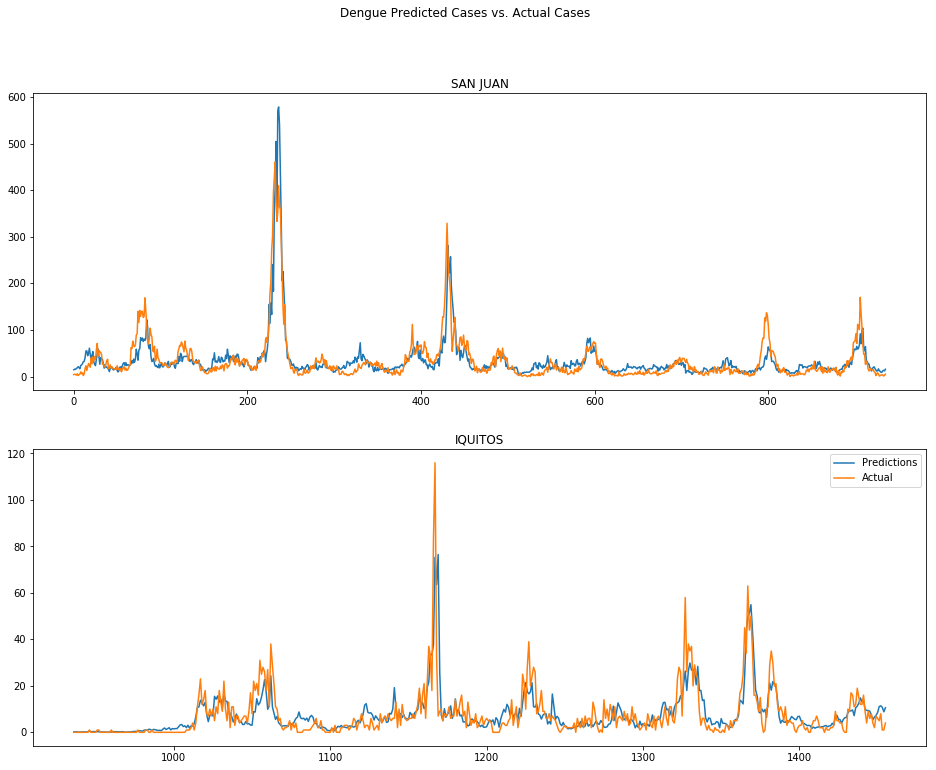

In [367]:
figs, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))

# plot sj
sj['fitted'] = sj_best_model.predict(X_sj)
sj.fitted.plot(ax=axes[0], label="Predictions")
sj.total_cases.plot(ax=axes[0], label="Actual", title="SAN JUAN")

# plot iq
iq['fitted'] = iq_best_model.predict(X_iq)
iq.fitted.plot(ax=axes[1], label="Predictions")
iq.total_cases.plot(ax=axes[1], label="Actual", title="IQUITOS")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [300]:
sj_predictions = sj_best_model.predict(X_sj_t).astype(int)
iq_predictions = iq_best_model.predict(X_iq_t).astype(int)

submission = pd.read_csv("DengueProject/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

submission.to_csv("NGB1.csv")